# Overview
* Install haptools to process the vcf file (https://haptools.readthedocs.io/en/stable/index.html)
* Get the vcf data from 1000 Genomes (In our project we will be using chr 21)
* Convert VCF file (.vcf.gz) to a hap file (.hap)
* Simulate phenotypes

# Installing haptools 

In [6]:
# Allows us to run haptools in your directory
pip install haptools
ls ~/.local/bin/
export PATH=$PATH:$HOME/.local/bin

# Retriving the Real World Data

Chromosome 21 Real Data For Genotypes (1000 Genomes phase 1 release)
ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz

In [ ]:
# wget [insert .vcf.gz file here]
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz
    
# zcat [insert .vcf.gz file here] | less -S
zcat ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz | less -S

# "ctrl+v" to scroll through the page to look for variants you are interested in

# Converting .vcf files to .hap

The code below was used from the haptools documentation: https://haptools.readthedocs.io/en/stable/api/examples.html#api-examples-snps2hap (given permission to use this pre-written code)

In [2]:
from haptools import data
from haptools.sim_phenotype import Haplotype

# which variants do we want to write to the haplotype file?
variants = {"rs149635655", "rs141306699"}

# load the genotypes file
# you can use either a VCF or PGEN file
gt = data.GenotypesVCF("ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz")
gt.read(variants=variants)

# initialize an empty haplotype file
hp = data.Haplotypes("output.hap", haplotype=Haplotype)
hp.data = {}

for variant in gt.variants:
    ID, chrom, pos, alleles = variant[["id", "chrom", "pos", "alleles"]]
    end = pos + len(alleles[1])

    # create a haplotype line in the .hap file
    # you should fill out "beta" with your own value
    hp.data[ID] = Haplotype(chrom=chrom, start=pos, end=end, id=ID, beta=0.5)

    # create variant lines for each haplotype
    hp.data[ID].variants = (data.Variant(start=pos, end=end, id=ID, allele=alleles[1]),)

hp.write()

[W::bcf_hdr_check_sanity] GL should be declared as Number=G


# Use haptools to simulate phenotypes

haptools simphenotype \
--replications INT \
--heritability FLOAT \
--prevalence FLOAT \
--region TEXT \
--sample SAMPLE --sample SAMPLE \
--samples-file FILENAME \
--id ID --id ID \
--ids-file FILENAME \
--chunk-size INT \
--output PATH \
--verbosity [CRITICAL|ERROR|WARNING|INFO|DEBUG|NOTSET] \
GENOTYPES HAPLOTYPES

In [8]:
# Index the .vcf.gz file using tabix so we can retrieve information from the file faster
tabix -p vcf ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz

# Uses the haptools function simphenotype to simulate phenotypes for our genotypes so we can run GWAS on it
haptools simphenotype ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz output.hap -o simulated.pheno

Defaulting to user installation because normal site-packages is not writeable


/bin/sh: 1: /opt/k8s-support/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/sources/homer/bin:/sources/meme-5.0.5/src/:/home/jtliew/.local/bin: not found
sh: 1: haptools: not found


32512

# Retrieve Statistics About Our Dataset

Populating the interactive namespace from numpy and matplotlib
There are 1092 samples in VCF file
Of those, 1092 samples have phenotype values
There are this many total variants:
[W::bcf_hdr_check_sanity] GL should be declared as Number=G
[W::hts_idx_load2] The index file is older than the data file: /home/jtliew/teams/31/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz.tbi
[W::hts_idx_load2] The index file is older than the data file: /home/jtliew/teams/31/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz.tbi
518965


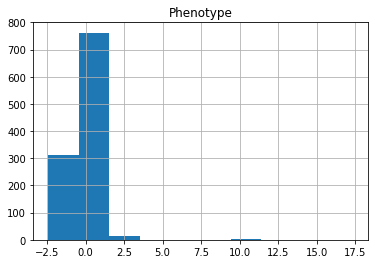

In [12]:
%pylab inline
import os
import pandas as pd

# Plot histogram of LDL values. Should be a nice bell shaped curve
#ptdata = pd.read_csv(os.environ["HOME"]+"/teams/31/simulated.pheno",sep)
data = pd.read_csv(os.environ["HOME"]+"/teams/31/simulated.pheno", delim_whitespace=True, comment='#', header=None, names=['IID', 'Phenotype'])
data.hist("Phenotype");

# Print out sample info
import vcf
reader = vcf.Reader(open(os.environ["HOME"]+"/teams/31/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz", "rb"))
print("There are {numsamp} samples in VCF file".format(numsamp=len(reader.samples)))
numsamp_withpt = len(set(data["IID"]).intersection(set(reader.samples)))
print("Of those, {numsamp} samples have phenotype values".format(numsamp=numsamp_withpt))

# Print out variant info
print("There are this many total variants:")
!bcftools index -n ~/teams/31/ALL.chr21.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz;